In [0]:
# Colab preporation

In [0]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

E: Package 'python-software-properties' has no installation candidate
Selecting previously unselected package google-drive-ocamlfuse.
(Reading database ... 131183 files and directories currently installed.)
Preparing to unpack .../google-drive-ocamlfuse_0.7.13-0ubuntu1~ubuntu18.04.1_amd64.deb ...
Unpacking google-drive-ocamlfuse (0.7.13-0ubuntu1~ubuntu18.04.1) ...
Setting up google-drive-ocamlfuse (0.7.13-0ubuntu1~ubuntu18.04.1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope

In [0]:
!mkdir -p drive
!google-drive-ocamlfuse drive

In [0]:
!cd drive/colab/Zolotich/

In [0]:
!ls

adc.json  drive  sample_data


# Лабораторная: Первичный анализ данных

In [0]:
import pandas as pd
import numpy as np
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import copy
%matplotlib inline

In [0]:
def plot_hist_categorial_attribute(data, attribute): 
    """
    Функция отображения распределния категориальных признаков.
    """
    counts = []
    values = set(data[attribute])
    for i in values:
        counts.append(data[data[attribute] == i].count()[0])
        print("{} - {:f} %".format(i,(counts[-1]/len(data[attribute]))*100))
    plt.subplots(figsize=(8,5))
    values = list(values)
    plt.barh(values,counts, color='r')

В данном Jupyter Notebook будет рассмотрена задача классификации статуса заемщика банковской организации. Требуется используя данные о кредитном рейтинге, цели получения кредитных средств, годового дохода и прочих признаков обучить классификатор предсказывать будет ли выплачен должником кредит.

In [0]:
df_train = pd.read_csv("drive/colab/Zolotich/credit_train.csv")

In [0]:
df_train

,Loan ID,Customer ID,Loan Status,Current Loan Amount,Term,Credit Score,Annual Income,Years in current job,Home Ownership,Purpose,Monthly Debt,Years of Credit History,Months since last delinquent,Number of Open Accounts,Number of Credit Problems,Current Credit Balance,Maximum Open Credit,Bankruptcies,Tax Liens
0,14dd8831-6af5-400b-83ec-68e61888a048,981165ec-3274-42f5-a3b4-d104041a9ca9,Fully Paid,445412.0,Short Term,709.0,1167493.0,8 years,Home Mortgage,Home Improvements,5214.74,17.2,NaN,6.0,1.0,228190.0,416746.0,1.0,0.0
1,4771cc26-131a-45db-b5aa-537ea4ba5342,2de017a3-2e01-49cb-a581-08169e83be29,Fully Paid,262328.0,Short Term,NaN,NaN,10+ years,Home Mortgage,Debt Consolidation,33295.98,21.1,8.0,35.0,0.0,229976.0,850784.0,0.0,0.0
2,4eed4e6a-aa2f-4c91-8651-ce984ee8fb26,5efb2b2b-bf11-4dfd-a572-3761a2694725,Fully Paid,99999999.0,Short Term,741.0,2231892.0,8 years,Own Home,Debt Consolidation,29200.53,14.9,29.0,18.0,1.0,297996.0,750090.0,0.0,0.0
3,77598f7b-32e7-4e3b-a6e5-06ba0d98fe8a,e777faab-98ae-45af-9a86-7ce5b33b1011,Fully Paid,347666.0,Long Term,721.0,806949.0,3 years,Own Home,Debt Consolidation,8741.90,12.0,NaN,9.0,0.0,256329.0,386958.0,0.0,0.0
4,d4062e70-befa-4995-8643-a0de73938182,81536ad9-5ccf-4eb8-befb-47a4d608658e,Fully Paid,176220.0,Short Term,NaN,NaN,5 years,Rent,Debt Consolidation,20639.70,6.1,NaN,15.0,0.0,253460.0,427174.0,0.0,0.0
5,89d8cb0c-e5c2-4f54-b056-48a645c543dd,4ffe99d3-7f2a-44db-afc1-40943f1f9750,Charged Off,206602.0,Short Term,7290.0,896857.0,10+ years,Home Mortgage,Debt Consolidation,16367.74,17.3,NaN,6.0,0.0,215308.0,272448.0,0.0,0.0
6,273581de-85d8-4332-81a5-19b04ce68666,90a75dde-34d5-419c-90dc-1e58b04b3e35,Fully Paid,217646.0,Short Term,730.0,1184194.0,< 1 year,Home Mortgage,Debt Consolidation,10855.08,19.6,10.0,13.0,1.0,122170.0,272052.0,1.0,0.0
7,db0dc6e1-77ee-4826-acca-772f9039e1c7,018973c9-e316-4956-b363-67e134fb0931,Charged Off,648714.0,Long Term,NaN,NaN,< 1 year,Home Mortgage,Buy House,14806.13,8.2,8.0,15.0,0.0,193306.0,864204.0,0.0,0.0
8,8af915d9-9e91-44a0-b5a2-564a45c12089,af534dea-d27e-4fd6-9de8-efaa52a78ec0,Fully Paid,548746.0,Short Term,678.0,2559110.0,2 years,Rent,Debt Consolidation,18660.28,22.6,33.0,4.0,0.0,437171.0,555038.0,0.0,0.0
9,0b1c4e3d-bd97-45ce-9622-22732fcdc9a0,235c4a43-dadf-483d-aa44-9d6d77ae4583,Fully Paid,215952.0,Short Term,739.0,1454735.0,< 1 year,Rent,Debt Consolidation,39277.75,13.9,NaN,20.0,0.0,669560.0,1021460.0,0.0,0.0


# Описание признаков

- К сожалению, для данного набора данных отсутсвует описание или пояснение, поэтому интерпретация признаков следует из их названия и принимаемых значений
- Loan ID - ID кредита, не требуется для классификации
- Customer ID - ID клиента, не требуется для классификации
- Loan Status - целевой признак, принимает значения (Т.к. целевой признак принимает только 2 значения, задача относится к бинаркой классификации): 
    - "Fully Paid" - полностью выплачен, 
    - "Charged Off" - списан, метка означает, что с возвратом средств у кредитора будут проблемы. 
- Current Loan Amount - текущая сумма кредита
- Term - срок кредита, принимает значения:
    - "Long Term" - долгосрочный, 
    - "Short Term" - кратковременный
- Credit Score - кредитный рейтинг заемщика
- Annual Income	- годовой доход
- Years in current job - стаж на текущей работе
- Home Ownership - место проживания, принимает значения: 
    - "HaveMortgage" - недвижимость в ипотеке, 
    - "Home Mortgage" - недвижимость в ипотеке ( предположение, что оба значения имеют одинаковый смысл??? ), 
    - "Own Home" - собственный дом, 
    - "Rent" - арендует жилье
- Purpose - цель кредита, принимает значения (В данном признаке так же присуствует значения, которые имеют одинаковый смысл, стоит попробовать объединить их,  например "Other" и "other", "vacation" и "Take a Trip" и т.д.): 
    - "Business Loan", 
    - "Buy House", 
    - "Buy a Car", 
    - "Debt Consolidation", 
    - "Educational Expenses", 
    - "Home Improvements", 
    - "Medical Bills", 
    - "Other", 
    - "Take a Trip", 
    - "major_purchase", 
    - "moving", 
    - "other", 
    - "renewable_energy", 
    - "small_business", 
    - "vacation", 
    - "wedding". 
- Monthly Debt	- ежемесячный платеж
- Years of Credit History - количество лет, с кредитной историей
- Months since last delinquent - количество месяцев, с последнего правонарушения
- Number of Open Accounts - количество открытых счетов
- Number of Credit Problems - количество проблем с кредитами
- Current Credit Balance - количество средств на счету, сумма которой может свободно распоряжется заемщик
- Maximum Open Credit - оценка всех средств заемщика
- Bankruptcies - наличие банкротсва у заемщика
- Tax Liens - налоговые льготы


Сразу уберем признаки "Loan ID", "Customer ID" так как из за них возможно неправильная работа классификатора и они не несут в себе никакой полезной информации

In [0]:
df_train = df_train.drop(["Loan ID", "Customer ID"], axis = 1)
df_train

,Loan Status,Current Loan Amount,Term,Credit Score,Annual Income,Years in current job,Home Ownership,Purpose,Monthly Debt,Years of Credit History,Months since last delinquent,Number of Open Accounts,Number of Credit Problems,Current Credit Balance,Maximum Open Credit,Bankruptcies,Tax Liens
0,Fully Paid,445412.0,Short Term,709.0,1167493.0,8 years,Home Mortgage,Home Improvements,5214.74,17.2,NaN,6.0,1.0,228190.0,416746.0,1.0,0.0
1,Fully Paid,262328.0,Short Term,NaN,NaN,10+ years,Home Mortgage,Debt Consolidation,33295.98,21.1,8.0,35.0,0.0,229976.0,850784.0,0.0,0.0
2,Fully Paid,99999999.0,Short Term,741.0,2231892.0,8 years,Own Home,Debt Consolidation,29200.53,14.9,29.0,18.0,1.0,297996.0,750090.0,0.0,0.0
3,Fully Paid,347666.0,Long Term,721.0,806949.0,3 years,Own Home,Debt Consolidation,8741.90,12.0,NaN,9.0,0.0,256329.0,386958.0,0.0,0.0
4,Fully Paid,176220.0,Short Term,NaN,NaN,5 years,Rent,Debt Consolidation,20639.70,6.1,NaN,15.0,0.0,253460.0,427174.0,0.0,0.0
5,Charged Off,206602.0,Short Term,7290.0,896857.0,10+ years,Home Mortgage,Debt Consolidation,16367.74,17.3,NaN,6.0,0.0,215308.0,272448.0,0.0,0.0
6,Fully Paid,217646.0,Short Term,730.0,1184194.0,< 1 year,Home Mortgage,Debt Consolidation,10855.08,19.6,10.0,13.0,1.0,122170.0,272052.0,1.0,0.0
7,Charged Off,648714.0,Long Term,NaN,NaN,< 1 year,Home Mortgage,Buy House,14806.13,8.2,8.0,15.0,0.0,193306.0,864204.0,0.0,0.0
8,Fully Paid,548746.0,Short Term,678.0,2559110.0,2 years,Rent,Debt Consolidation,18660.28,22.6,33.0,4.0,0.0,437171.0,555038.0,0.0,0.0
9,Fully Paid,215952.0,Short Term,739.0,1454735.0,< 1 year,Rent,Debt Consolidation,39277.75,13.9,NaN,20.0,0.0,669560.0,1021460.0,0.0,0.0


# Анализ признаков

Вычислим статистические параметры признаков, среднее, стандартное отклонение и т.п.

In [0]:
df_train.describe()

,Current Loan Amount,Credit Score,Annual Income,Monthly Debt,Years of Credit History,Months since last delinquent,Number of Open Accounts,Number of Credit Problems,Current Credit Balance,Maximum Open Credit,Bankruptcies,Tax Liens
count,1.000000e+05,80846.000000,8.084600e+04,100000.000000,100000.000000,46859.000000,100000.00000,100000.000000,1.000000e+05,9.999800e+04,99796.000000,99990.000000
mean,1.176045e+07,1076.456089,1.378277e+06,18472.412336,18.199141,34.901321,11.12853,0.168310,2.946374e+05,7.607984e+05,0.117740,0.029313
std,3.178394e+07,1475.403791,1.081360e+06,12174.992609,7.015324,21.997829,5.00987,0.482705,3.761709e+05,8.384503e+06,0.351424,0.258182
min,1.080200e+04,585.000000,7.662700e+04,0.000000,3.600000,0.000000,0.00000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000
25%,1.796520e+05,705.000000,8.488440e+05,10214.162500,13.500000,16.000000,8.00000,0.000000,1.126700e+05,2.734380e+05,0.000000,0.000000
50%,3.122460e+05,724.000000,1.174162e+06,16220.300000,16.900000,32.000000,10.00000,0.000000,2.098170e+05,4.678740e+05,0.000000,0.000000
75%,5.249420e+05,741.000000,1.650663e+06,24012.057500,21.700000,51.000000,14.00000,0.000000,3.679588e+05,7.829580e+05,0.000000,0.000000
max,1.000000e+08,7510.000000,1.655574e+08,435843.280000,70.500000,176.000000,76.00000,15.000000,3.287897e+07,1.539738e+09,7.000000,15.000000


Заметим сразу что количество значений в разных признак разнится, это значит что в данных присутсвуют пропуски, займемся ими позже. Min всех признаков не отрицательные, явных выбросов по этому параметру не наблюдаем. По Max есть странные значения в "Years of Credit History" - 70 лет, "Number of Open Accounts" - 76, "Bankruptcies" - 15, "Tax Liens" - 7. Рассмотрим распределения этих параметров в дальнейшем. Std для некоторых признаков больше медианы, разброс данных достаточно велик. 

Удалим объекты, для которых целевой признак равен Nan, т.к. мы не сможем его востановить не внося искажения в датасет.

In [0]:
df_train = df_train.dropna(subset=['Loan Status']) 
df_train.shape

(100000, 17)

In [0]:
Fully_Paid = df_train[df_train['Loan Status'] == "Fully Paid"]
Charged_Off = df_train[df_train['Loan Status'] == "Charged Off"]
print("Процент класса Fully_Paid {:f}%".format(len(Fully_Paid)/len(df_train)))
print("Процент класса Charged_Off {:f}%".format(len(Charged_Off)/len(df_train)))

Процент класса Fully_Paid 0.773610%
Процент класса Charged_Off 0.226390%


Классы не сбалансированы

Рассмотрим детальнее признаки

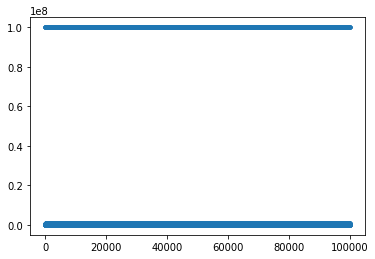

In [0]:
plt.plot(df_train["Current Loan Amount"], ".") # посмотрим распределние данных "Current Loan Amount", картина свидетельствует 
pass                                           # о выбросах в высоких значениях

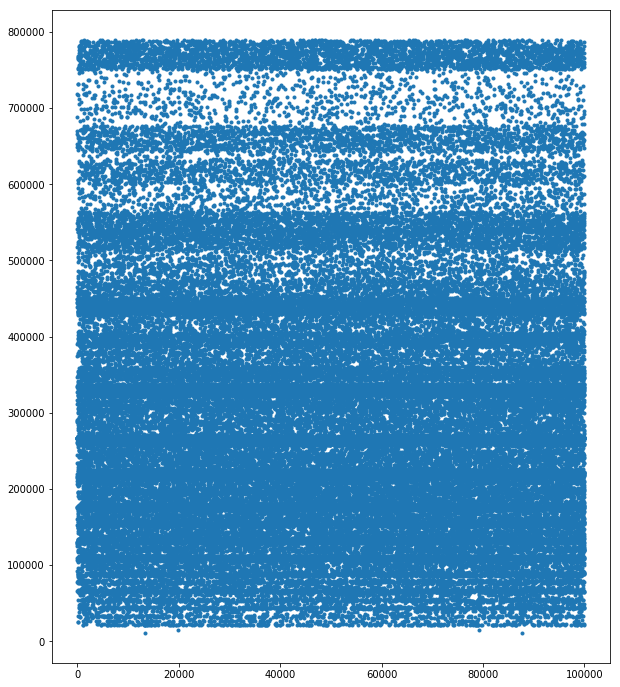

In [0]:
df_train["Current Loan Amount"].max() # найдем эти выбросы
# df_train = df_train[df_train["Current Loan Amount"] == 99999999.0]["Current Loan Amount"]
df_train = df_train.replace({'Current Loan Amount': {99999999.0: df_train[df_train["Current Loan Amount"] != 99999999.0]["Current Loan Amount"].median()}})
plt.figure(figsize=(10,12))
plt.plot(df_train["Current Loan Amount"], ".")
pass

In [0]:
df_train.shape

(100000, 17)

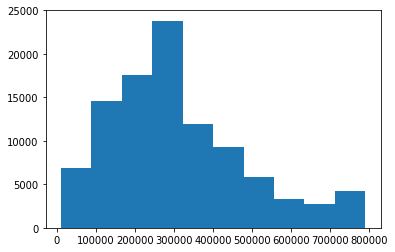

In [0]:
plt.hist(df_train["Current Loan Amount"]) # пик в центре вырос из за заполнения выбросов медианой
pass

Гистограмма "Current Loan Amount" признака выглядит адекватно, очевидных выбросов больше не наблюдается.

Рассмотрим количество пропущенных данных в признаках

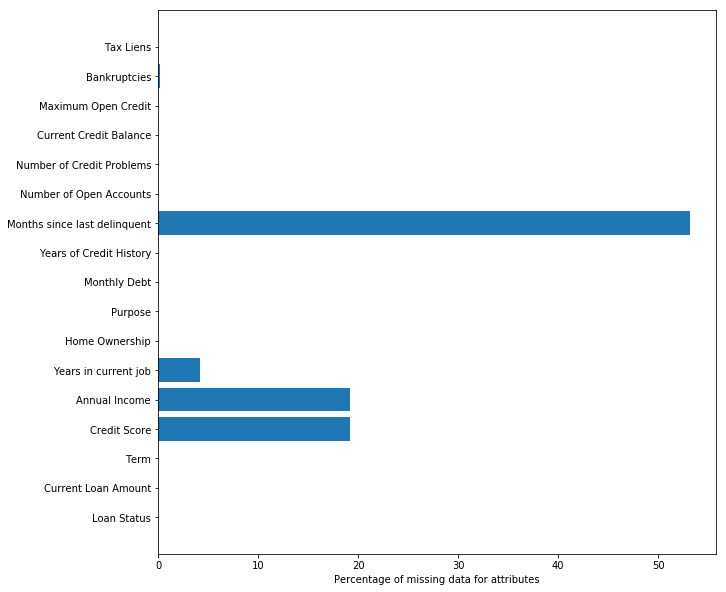

In [0]:
plt.figure(figsize=(10,10))
plt.barh(df_train.columns, (df_train.isnull().sum()/len(df_train))*100)
plt.xlabel("Percentage of missing data for attributes")
pass

Для признака "Months since last delinquent" пропущено более 50% данных, исключим его из набора данных. Остальные признаки попробуем заполнить медианой после первичного анализа

In [0]:
df_train = df_train.drop(["Months since last delinquent"], axis = 1)
df_train

,Loan Status,Current Loan Amount,Term,Credit Score,Annual Income,Years in current job,Home Ownership,Purpose,Monthly Debt,Years of Credit History,Number of Open Accounts,Number of Credit Problems,Current Credit Balance,Maximum Open Credit,Bankruptcies,Tax Liens
0,Fully Paid,445412.0,Short Term,709.0,1167493.0,8 years,Home Mortgage,Home Improvements,5214.74,17.2,6.0,1.0,228190.0,416746.0,1.0,0.0
1,Fully Paid,262328.0,Short Term,NaN,NaN,10+ years,Home Mortgage,Debt Consolidation,33295.98,21.1,35.0,0.0,229976.0,850784.0,0.0,0.0
2,Fully Paid,267344.0,Short Term,741.0,2231892.0,8 years,Own Home,Debt Consolidation,29200.53,14.9,18.0,1.0,297996.0,750090.0,0.0,0.0
3,Fully Paid,347666.0,Long Term,721.0,806949.0,3 years,Own Home,Debt Consolidation,8741.90,12.0,9.0,0.0,256329.0,386958.0,0.0,0.0
4,Fully Paid,176220.0,Short Term,NaN,NaN,5 years,Rent,Debt Consolidation,20639.70,6.1,15.0,0.0,253460.0,427174.0,0.0,0.0
5,Charged Off,206602.0,Short Term,7290.0,896857.0,10+ years,Home Mortgage,Debt Consolidation,16367.74,17.3,6.0,0.0,215308.0,272448.0,0.0,0.0
6,Fully Paid,217646.0,Short Term,730.0,1184194.0,< 1 year,Home Mortgage,Debt Consolidation,10855.08,19.6,13.0,1.0,122170.0,272052.0,1.0,0.0
7,Charged Off,648714.0,Long Term,NaN,NaN,< 1 year,Home Mortgage,Buy House,14806.13,8.2,15.0,0.0,193306.0,864204.0,0.0,0.0
8,Fully Paid,548746.0,Short Term,678.0,2559110.0,2 years,Rent,Debt Consolidation,18660.28,22.6,4.0,0.0,437171.0,555038.0,0.0,0.0
9,Fully Paid,215952.0,Short Term,739.0,1454735.0,< 1 year,Rent,Debt Consolidation,39277.75,13.9,20.0,0.0,669560.0,1021460.0,0.0,0.0


Рассмотрим следующие признаки

Short Term - 72.208000 %
Long Term - 27.792000 %


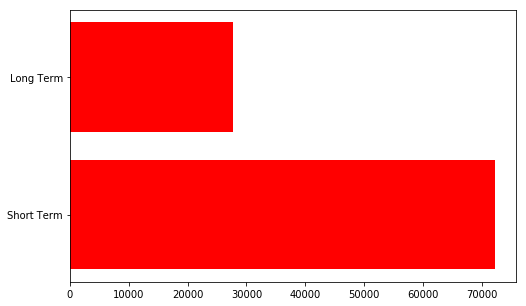

In [0]:
plot_hist_categorial_attribute(df_train, "Term")

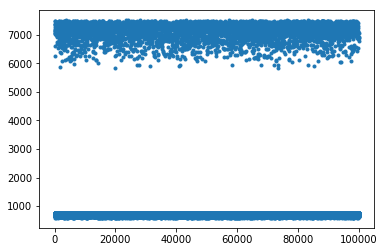

In [0]:
plt.plot(df_train["Credit Score"], ".") # посмотрим распределние данных "Credit Score" 
pass

Разделение признака на два непересекающихся кластера, странная ситуация, рассмотрим подробнее

4551


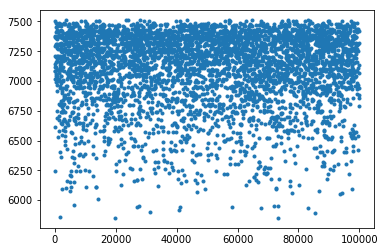

In [0]:
Credit_Score = df_train["Credit Score"][df_train["Credit Score"]>2000 ]
print(len(Credit_Score))
plt.plot(Credit_Score, ".") 
pass

76295


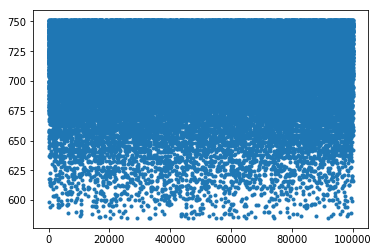

In [0]:
Credit_Score = df_train["Credit Score"][df_train["Credit Score"]<2000 ]
print(len(Credit_Score))
plt.plot(Credit_Score, ".") 
pass

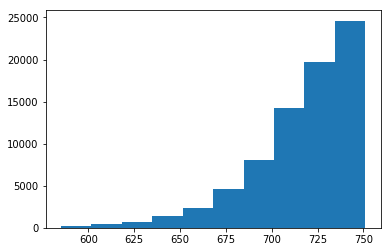

In [0]:
plt.hist(Credit_Score) 
pass

Разобъем данные на 2 кластера

In [0]:
df_train2 = df_train[df_train["Credit Score"].isnull()]
df_train3 = df_train[df_train["Credit Score"]<2000 ]
lower = df_train3.append(df_train2)
lower["Credit Score"] = lower["Credit Score"].fillna(lower["Credit Score"].median()) # заполним пропуски медианой

Charged Off - 100.000000 %


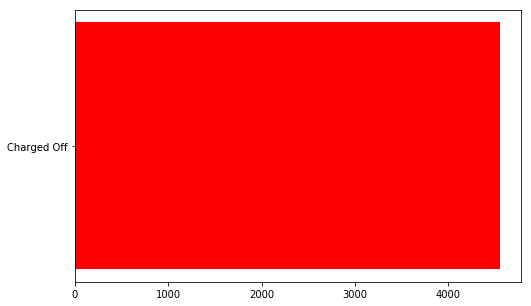

In [0]:
upper = df_train[df_train["Credit Score"]>2000]
plot_hist_categorial_attribute(upper, "Loan Status")

Все объекты для которых "Credit Score" > 2000 принадлежат к классу "Charged Off". В итоговой модели, следует это использовать.

Fully Paid - 81.049566 %
Charged Off - 18.950434 %


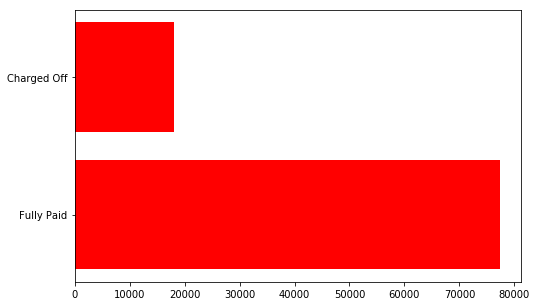

In [0]:
plot_hist_categorial_attribute(lower, "Loan Status")

In [0]:
df_train = copy.deepcopy(lower)


Поискав в интернете информацию про "Credit Score" находим возможную интерпретацию значений данного признака. Для кластера lower эта интерпретация вполне совпадает.

In [0]:
from IPython.core.display import HTML 
from IPython.display import Image
Image(url= "https://www.experian.com/blogs/ask-experian/wp-content/img/experian-good-score-ranges-fico.png")

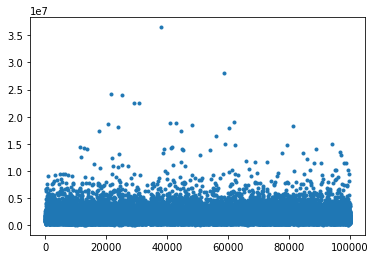

In [0]:
plt.plot(df_train["Annual Income"], ".") # на графике видим выбросы
pass

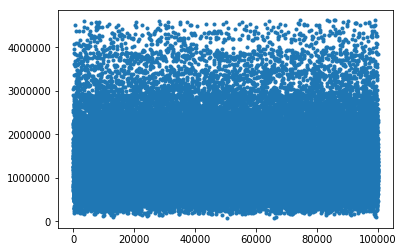

In [0]:
plt.plot(df_train["Annual Income"][df_train["Annual Income"]<df_train['Annual Income'].quantile(0.99)], ".") # уберем их с помощью квантилей
# print(len(df_train["Annual Income"][df_train["Annual Income"]<df_train['Annual Income'].quantile(0.99)]))
pass

In [0]:
df_train.shape

(95449, 16)

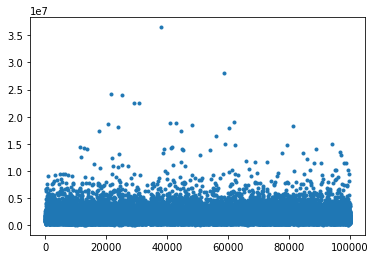

In [0]:
plt.plot(df_train["Annual Income"], ".")
pass

(95386, 16)

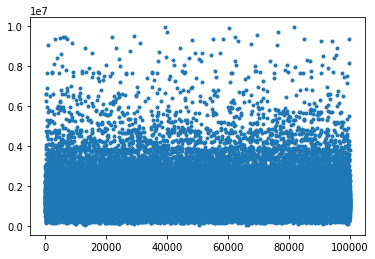

In [0]:
plt.plot(df_train[df_train["Annual Income"]<0.01*10**9]["Annual Income"], ".")

df_train2 = df_train[df_train["Annual Income"].isnull()]
df_train3 = df_train[df_train["Annual Income"]<0.01*10**9 ]
df_train4 = df_train3.append(df_train2)
df_train4["Annual Income"] = df_train4["Annual Income"].fillna(df_train4["Annual Income"].median()) # заполним пропуски медианой
df_train = copy.deepcopy(df_train4)
df_train.shape

# df_train = df_train[df_train["Annual Income"]<0.02*10**8]
# df_train = df_train[df_train["Annual Income"]<0.01*10**9]
# df_train.shape


Рассмотрим распределение "Years in current job" без пропущенных значений

7 years - 5.786019 %
6 years - 5.914014 %
4 years - 6.448966 %
9 years - 4.124275 %
5 years - 7.104256 %
2 years - 9.550377 %
10+ years - 32.533640 %
1 year - 6.700580 %
3 years - 8.522044 %
< 1 year - 8.527513 %
8 years - 4.788316 %


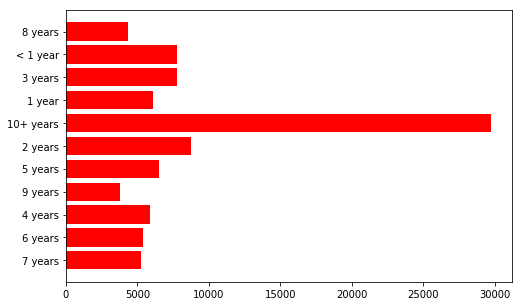

In [0]:
plot_hist_categorial_attribute(df_train.dropna(subset=["Years in current job"]), "Years in current job")

Распределение выглядит адекватно, заменим пропуски модой

In [0]:
tmp = {"Years in current job":"10+ years"}
df_train = df_train.fillna(tmp)

Рассмотрим признак "Home Ownership"

Rent - 42.008261 %
Home Mortgage - 48.613004 %
HaveMortgage - 0.217013 %
Own Home - 9.161722 %


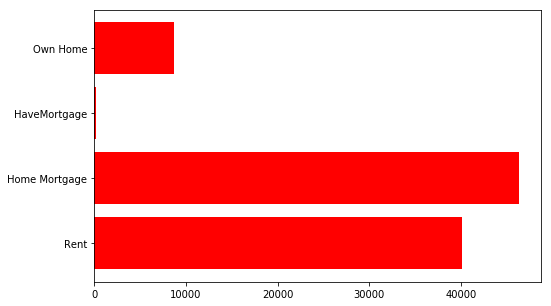

In [0]:
plot_hist_categorial_attribute(df_train, "Home Ownership")

Из графика видно что "HaveMortgage" встречается очень редко, лишь в 0.22% и по смыслу совпадает с "Home Mortgage". Приведем их к одному значению

In [0]:
df_train = df_train.replace({'Home Ownership': {"HaveMortgage": "Home Mortgage"}})

Home Improvements - 5.881366 %
Take a Trip - 0.575556 %
other - 6.056444 %
Medical Bills - 1.121758 %
vacation - 0.100644 %
renewable_energy - 0.009435 %
wedding - 0.119514 %
Buy House - 0.676200 %
Business Loan - 1.548445 %
Educational Expenses - 0.100644 %
small_business - 0.274673 %
Other - 3.287694 %
Buy a Car - 1.275869 %
moving - 0.146772 %
Debt Consolidation - 78.477974 %
major_purchase - 0.347011 %


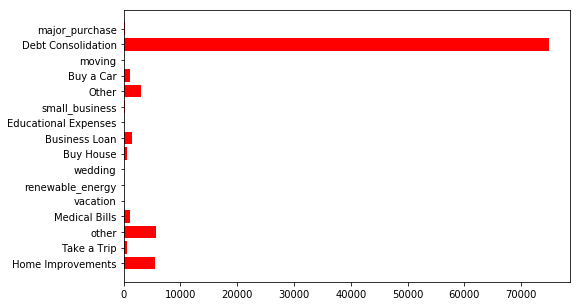

In [0]:
plot_hist_categorial_attribute(df_train, "Purpose")

Преобладает значение 'Debt Consolidation'. Заменим "other": "Other" и "Take a Trip": "vacation" чтобы уменьшить число возможных значений, т.ек препологаем что по смыслу это одно и то же

In [0]:
df_train = df_train.replace({'Purpose': {"other": "Other"}})
df_train = df_train.replace({'Purpose': {"Take a Trip": "vacation"}})

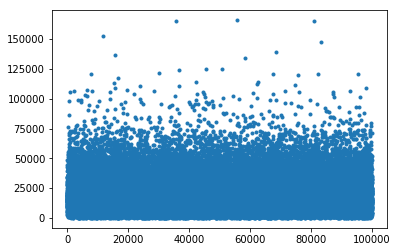

In [0]:
plt.plot(df_train["Monthly Debt"], ".")
pass

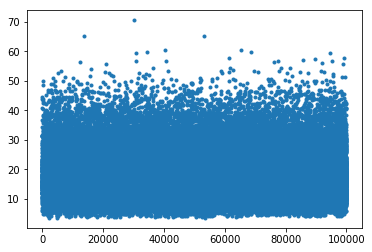

In [0]:
plt.plot(df_train["Years of Credit History"], ".")
pass

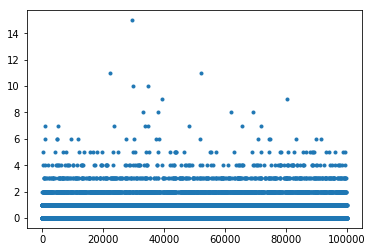

In [0]:
plt.plot(df_train["Number of Credit Problems"], ".")
pass

Явных выбросов не наблюдаем

Очистим последние признаки от выбросов и пустых значений

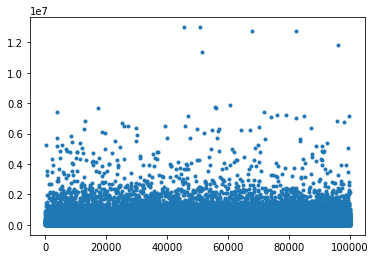

In [0]:
plt.plot(df_train["Current Credit Balance"], '.')
pass

In [0]:
df_train = df_train[df_train["Current Credit Balance"]<1*10**7] 
df_train.shape

(95380, 16)

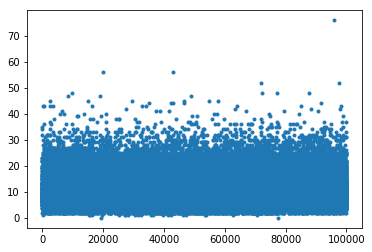

In [0]:
plt.plot(df_train["Number of Open Accounts"], ".")
pass

In [0]:
df_train = df_train[df_train["Number of Open Accounts"] < 60]


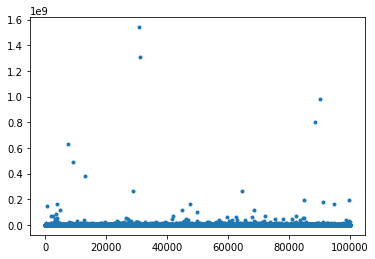

In [0]:
plt.plot(df_train["Maximum Open Credit"], '.')
pass

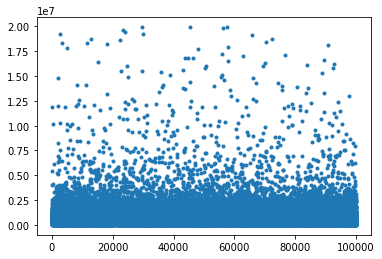

In [0]:
 plt.plot(df_train[df_train["Maximum Open Credit"] < 0.02*10**9]["Maximum Open Credit"], ".")
 pass


In [0]:
df_train = df_train[df_train["Maximum Open Credit"] < 0.02*10**9]

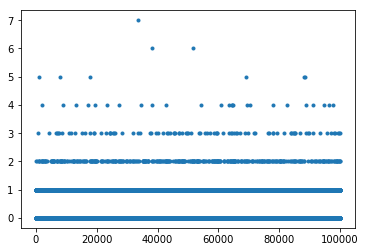

In [0]:
plt.plot(df_train["Bankruptcies"], ".") #Tax Liens
pass

Предпологается, что признак "Bankruptcies" бинарный, поэтому уберем все данные выше 1

In [0]:
print(len(df_train[df_train["Bankruptcies"]>=2]))
df_train = df_train[df_train["Bankruptcies"]<2]
df_train.shape

527


(94582, 16)

Ан-но ситуация с признаком "Tax Liens"

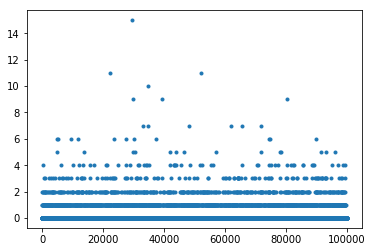

In [0]:
plt.plot(df_train["Tax Liens"], ".")
pass

In [0]:
print(len(df_train[df_train["Tax Liens"]>=2]))
df_train = df_train[df_train["Tax Liens"]<2]
df_train.shape


530


(94052, 16)

проверяем, избавились ли от всех пропущенных значений

In [0]:
df_train.isnull().sum()

Loan Status                  0
Current Loan Amount          0
Term                         0
Credit Score                 0
Annual Income                0
Years in current job         0
Home Ownership               0
Purpose                      0
Monthly Debt                 0
Years of Credit History      0
Number of Open Accounts      0
Number of Credit Problems    0
Current Credit Balance       0
Maximum Open Credit          0
Bankruptcies                 0
Tax Liens                    0
dtype: int64

Векторизуем категориальные признаки

In [0]:
df_train_copy = copy.deepcopy(df_train)

In [0]:
categorical_columns = [c for c in df_train.columns if df_train[c].dtype.name == 'object']
numerical_columns   = [c for c in df_train.columns if df_train[c].dtype.name != 'object']

In [0]:
data_describe = df_train.describe(include = [object])
for c in categorical_columns:
    df_train[c] = df_train[c].fillna(data_describe[c]['top'])

In [0]:
binary_columns    = [c for c in categorical_columns if data_describe[c]['unique'] == 2]
nonbinary_columns = [c for c in categorical_columns if data_describe[c]['unique'] > 2]
print(binary_columns, nonbinary_columns)

['Loan Status', 'Term'] ['Years in current job', 'Home Ownership', 'Purpose']


In [0]:
for binary in binary_columns:
  elements =  df_train[binary].unique()
  number = 0.0
  for i in elements:
    df_train.at[df_train[binary] == i, binary] = number
    number = number + 1.0

In [0]:
for nonbinary in nonbinary_columns:
  elements =  df_train[nonbinary].unique()
  number = 0.0
  for i in elements:
    df_train.at[df_train[nonbinary] == i, nonbinary] = number
    number = number + 1.0

In [0]:
df_train

,Loan Status,Current Loan Amount,Term,Credit Score,Annual Income,Years in current job,Home Ownership,Purpose,Monthly Debt,Years of Credit History,Number of Open Accounts,Number of Credit Problems,Current Credit Balance,Maximum Open Credit,Bankruptcies,Tax Liens
0,0,445412.0,0,709.0,1167493.0,0,0,0,5214.74,17.2,6.0,1.0,228190.0,416746.0,1.0,0.0
2,0,267344.0,0,741.0,2231892.0,0,1,1,29200.53,14.9,18.0,1.0,297996.0,750090.0,0.0,0.0
3,0,347666.0,1,721.0,806949.0,1,1,1,8741.90,12.0,9.0,0.0,256329.0,386958.0,0.0,0.0
6,0,217646.0,0,730.0,1184194.0,2,0,1,10855.08,19.6,13.0,1.0,122170.0,272052.0,1.0,0.0
8,0,548746.0,0,678.0,2559110.0,3,2,1,18660.28,22.6,4.0,0.0,437171.0,555038.0,0.0,0.0
9,0,215952.0,0,739.0,1454735.0,2,2,1,39277.75,13.9,20.0,0.0,669560.0,1021460.0,0.0,0.0
10,0,267344.0,0,728.0,714628.0,1,2,1,11851.06,16.0,16.0,0.0,203965.0,289784.0,0.0,0.0
12,0,267344.0,0,740.0,776188.0,2,1,1,11578.22,8.5,6.0,0.0,134083.0,220220.0,0.0,0.0
13,0,267344.0,0,743.0,1560907.0,4,2,1,17560.37,13.3,10.0,1.0,225549.0,496474.0,1.0,0.0
14,0,234124.0,0,727.0,693234.0,5,2,1,14211.24,24.7,10.0,1.0,28291.0,107052.0,1.0,0.0


Рассмотрим матрицу корреляции

In [0]:
corr = df_train.corr()
corr.style.background_gradient(cmap='coolwarm')

,Loan Status,Current Loan Amount,Term,Credit Score,Annual Income,Years in current job,Home Ownership,Purpose,Monthly Debt,Years of Credit History,Number of Open Accounts,Number of Credit Problems,Current Credit Balance,Maximum Open Credit,Bankruptcies,Tax Liens
Loan Status,1,0.0487339,0.103255,-0.0753676,-0.0707085,0.00670117,0.0506708,0.00511482,0.00803406,-0.0212692,0.0101728,-0.000226234,-0.00909424,-0.0364755,-0.00503308,0.00466579
Current Loan Amount,0.0487339,1,0.405886,-0.190187,0.376352,0.026001,-0.183033,-0.17598,0.412479,0.146585,0.18882,-0.0893133,0.337503,0.254781,-0.0943693,0.0114978
Term,0.103255,0.405886,1,-0.419666,0.107218,0.0198253,-0.116578,-0.0628464,0.159121,0.0416334,0.0821849,-0.0272641,0.115162,0.0737074,-0.0263534,-0.00405297
Credit Score,-0.0753676,-0.190187,-0.419666,1,-0.01445,-0.00677977,-0.038697,-0.0626963,-0.0821665,0.0703671,-0.0266575,-0.042375,-0.0173849,0.0792027,-0.0302192,-0.0146937
Annual Income,-0.0707085,0.376352,0.107218,-0.01445,1,0.0142835,-0.19929,-0.0269519,0.534463,0.184439,0.168391,-0.0428991,0.344087,0.272409,-0.0556729,0.0301178
Years in current job,0.00670117,0.026001,0.0198253,-0.00677977,0.0142835,1,-0.0665933,-0.0220048,0.036057,0.0455981,0.0184658,0.0147396,0.0279197,0.0161897,0.0153933,0.00598475
Home Ownership,0.0506708,-0.183033,-0.116578,-0.038697,-0.19929,-0.0665933,1,0.0953263,-0.208031,-0.199403,-0.137434,-0.00837357,-0.181344,-0.164884,-0.00462968,-0.00686534
Purpose,0.00511482,-0.17598,-0.0628464,-0.0626963,-0.0269519,-0.0220048,0.0953263,1,-0.0859547,-0.0272431,-0.0904321,-0.0139744,-0.0769503,-0.0384079,-0.0196427,-0.000447075
Monthly Debt,0.00803406,0.412479,0.159121,-0.0821665,0.534463,0.036057,-0.208031,-0.0859547,1,0.202512,0.417074,-0.0739642,0.496692,0.321657,-0.0821137,0.0167315
Years of Credit History,-0.0212692,0.146585,0.0416334,0.0703671,0.184439,0.0455981,-0.199403,-0.0272431,0.202512,1,0.133497,0.0699162,0.225729,0.209728,0.0736513,0.0141864


С целевым признаком другие признаки практически не корреляруют, нет коэф. корреляции который был бы по абсолютному значению больше 0.11. Сильная корреляция (>0.85) отсутсвует. Самая сильная корреляция для Банкротов с количеством проблем с кредитами, корреляция вполне очевидна. Корреляция Current Credit Balance и Maximum Open Credit подтверждает мои преположения о интерпретации данных признаков. Monthly Debt коррелирует с Annual Income и Current Loan Amount, чем больше зарплата тем более большие кредиты берут люди и им нужно больше платить ежемесячно.

Обработаем категориальные не бинарные признаки используя dummy переменные

In [0]:
data_nonbinary = pd.get_dummies(df_train_copy[nonbinary_columns])

In [0]:

for binary in binary_columns:
  elements =  df_train_copy[binary].unique()
  number = 0.0
  for i in elements:
    df_train_copy.at[df_train_copy[binary] == i, binary] = number
    number = number + 1.0

Нормализуем числовые признаки, чтобы они вносили один вклад в итоговую модель, т.к. данные отличаются на порядки

In [0]:
data_numerical = df_train_copy[numerical_columns]

In [0]:
data_numerical = (data_numerical - data_numerical.mean(axis = 0))/data_numerical.std(axis = 0)

In [0]:
data = pd.concat((data_numerical, data_nonbinary, df_train_copy[binary_columns]), axis = 1)
print(data.shape)

(94052, 41)


In [0]:
data

,Current Loan Amount,Credit Score,Annual Income,Monthly Debt,Years of Credit History,Number of Open Accounts,Number of Credit Problems,Current Credit Balance,Maximum Open Credit,Bankruptcies,Tax Liens,Years in current job_1 year,Years in current job_10+ years,Years in current job_2 years,Years in current job_3 years,Years in current job_4 years,Years in current job_5 years,Years in current job_6 years,Years in current job_7 years,Years in current job_8 years,Years in current job_9 years,Years in current job_< 1 year,Home Ownership_Home Mortgage,Home Ownership_Own Home,Home Ownership_Rent,Purpose_Business Loan,Purpose_Buy House,Purpose_Buy a Car,Purpose_Debt Consolidation,Purpose_Educational Expenses,Purpose_Home Improvements,Purpose_Medical Bills,Purpose_Other,Purpose_major_purchase,Purpose_moving,Purpose_renewable_energy,Purpose_small_business,Purpose_vacation,Purpose_wedding,Loan Status,Term
0,0.795248,-0.346281,-0.224637,-1.106245,-0.141229,-1.024475,2.280922,-0.192353,-0.284364,2.913358,-0.115492,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2,-0.222213,0.922629,1.231962,0.899866,-0.469323,1.376156,2.280922,0.016758,0.113453,-0.343243,-0.115492,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
3,0.236738,0.129560,-0.718031,-0.811243,-0.883006,-0.424317,-0.370452,-0.108060,-0.319913,-0.343243,-0.115492,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1
6,-0.506182,0.486441,-0.201782,-0.634502,0.201129,0.375893,2.280922,-0.509948,-0.457043,2.913358,-0.115492,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
8,1.385687,-1.575536,1.679751,0.018306,0.629077,-1.424580,-0.370452,0.433673,-0.119324,-0.343243,-0.115492,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
9,-0.515862,0.843322,0.168446,1.742699,-0.611972,1.776261,-0.370452,1.129820,0.437309,-0.343243,-0.115492,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
10,-0.222213,0.407134,-0.844369,-0.551200,-0.312408,0.976051,-0.370452,-0.264922,-0.435882,-0.343243,-0.115492,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
12,-0.222213,0.882975,-0.760126,-0.574020,-1.382278,-1.024475,-0.370452,-0.474261,-0.518900,-0.343243,-0.115492,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
13,-0.222213,1.001936,0.313739,-0.073688,-0.697562,-0.224265,2.280922,-0.200265,-0.189215,2.913358,-0.115492,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
14,-0.412029,0.367481,-0.873646,-0.353801,0.928641,-0.224265,2.280922,-0.791173,-0.653956,2.913358,-0.115492,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0


Подготовим данные для модели

In [0]:
X = data.drop('Loan Status', axis = 1) # выбрасываем столбец Loan Status
y = data['Loan Status']
feature_names = X.columns

In [0]:
feature_names

Index(['Current Loan Amount', 'Credit Score', 'Annual Income', 'Monthly Debt',
       'Years of Credit History', 'Number of Open Accounts',
       'Number of Credit Problems', 'Current Credit Balance',
       'Maximum Open Credit', 'Bankruptcies', 'Tax Liens',
       'Years in current job_1 year', 'Years in current job_10+ years',
       'Years in current job_2 years', 'Years in current job_3 years',
       'Years in current job_4 years', 'Years in current job_5 years',
       'Years in current job_6 years', 'Years in current job_7 years',
       'Years in current job_8 years', 'Years in current job_9 years',
       'Years in current job_< 1 year', 'Home Ownership_Home Mortgage',
       'Home Ownership_Own Home', 'Home Ownership_Rent',
       'Purpose_Business Loan', 'Purpose_Buy House', 'Purpose_Buy a Car',
       'Purpose_Debt Consolidation', 'Purpose_Educational Expenses',
       'Purpose_Home Improvements', 'Purpose_Medical Bills', 'Purpose_Other',
       'Purpose_major_purchase', 

отдельно будем хранить данные, для которых Credit Score >2000, т.е. для них точность предсказания у нас будет равна 100%, добавим эти данные в конце к итоговым метрикам. Я не стал использовать эти данные для обучения, т.к. это может вызвать переобучение, и я уже могу с веротностью 100% предсказывать ответ по этому признаку по конкретному порогу

In [0]:
upper_test = int(len(upper)/100*30)
upper_train = len(upper) - upper_test
upper_train

3186

подготовим данные для обучения

In [0]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)



In [0]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors = 10)
knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=10, p=2,
                     weights='uniform')

In [0]:
y_test_predict = knn.predict(X_test)
err_test  = np.mean(y_test  != y_test_predict)
err_test

0.19272753047916075

In [0]:
err_test  = np.mean((y_test  != y_test_predict).append(pd.Series([False for i in range(upper_test)]))) # добавим предикт полученный по жесткому правилу в начале

In [0]:
err_test


0.18383421791014504

In [0]:
added_accuracy = 0.19272753047916075 - 0.18383421791014504

In [0]:
cm

array([[22664,   275],
       [ 5163,  1479]])

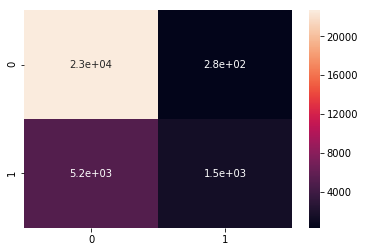

In [0]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_test_predict)
cm[1,1] = cm[1,1] + upper_test # добавим данные полученные разделением Credit_Score
sns.heatmap(cm, annot=True)

In [0]:
from sklearn.model_selection import GridSearchCV
nnb = [1, 3, 5, 10, 15, 20, 25, 35, 45, 55]
knn = KNeighborsClassifier()
grid = GridSearchCV(knn, param_grid = {'n_neighbors': nnb}, cv=10)
grid.fit(X_train, y_train)

best_cv_err = 1 - grid.best_score_
best_n_neighbors = grid.best_estimator_.n_neighbors
print(best_cv_err, best_n_neighbors)

0.1904125402515341 55


In [0]:
print(best_cv_err-added_accuracy)

0.18151922768251838


In [0]:
data_s1 = data[data["Loan Status"] == 0].sample(n=len(data[data["Loan Status"] == 1])) # Попробуем сбаланировать выборку, уменьшая ее размерность
data_s2 = data[data["Loan Status"] == 1]
data_s = data_s1.append(data_s2)

In [0]:
X = data_s.drop('Loan Status', axis = 1) # выбрасываем столбец Loan Status
y = data_s['Loan Status']


In [0]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)



In [0]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors = 10)
knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=10, p=2,
                     weights='uniform')

In [0]:
y_test_predict = knn.predict(X_test)

err_test  = np.mean(y_test  != y_test_predict)
err_test

0.44838558727187644

In [0]:
y_test_predict = knn.predict(X_test)
err_test  = np.mean((y_test  != y_test_predict).append(pd.Series([False for i in range(upper_test)])))

In [0]:
err_test


0.39759336099585063

In [0]:
added_accuracy = 0.44838558727187644 - 0.39759336099585063

In [0]:
cm

array([[3411, 1917],
       [2874, 2483]])

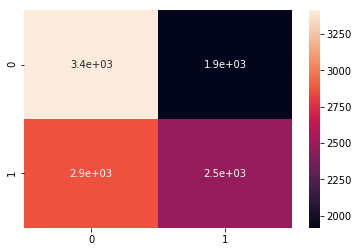

In [0]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_test_predict)
sns.heatmap(cm, annot=True)

In [0]:
from sklearn.model_selection import GridSearchCV
nnb = [1, 3, 5, 10, 15, 20, 25, 35, 45, 55]
knn = KNeighborsClassifier()
grid = GridSearchCV(knn, param_grid = {'n_neighbors': nnb}, cv=10)
grid.fit(X_train, y_train)

best_cv_err = 1 - grid.best_score_
best_n_neighbors = grid.best_estimator_.n_neighbors
print(best_cv_err, best_n_neighbors)

0.4256548072680598 55


In [0]:
print(best_cv_err-added_accuracy)

0.374862580992034


Уменьшение обучающей выборки значительно ухудшает результат